In [1]:
from ExpandedHeatNetwork import ExpandedHeatNetwork
from silent_optimize import silent_optimize
from Plot_scripts.DispatchSoCHeatInternational import PlotInternationalDispatchSoCHeat
from Plot_scripts.AnnualElectricityMix import AnnualElectricityMix

setup = {'DK': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            'industrial heat pump high temperature': True,
            },
        # 'DE': 
        #     {'OCGT': True,
        #     'battery storage': True,
        #     'onwind': True,
        #     'solar': True,
        #     'electrolysis': True,
        #     'fuel cell': True,
        #     'H2 (l) storage tank': True,
        #     'industrial heat pump high temperature': True,
        #     },
        'NO': 
            {'OCGT': True,
            'battery storage': True,
            'onwind': True,
            'solar': True,
            'electrolysis': True,
            'fuel cell': True,
            'H2 (l) storage tank': True,
            'industrial heat pump high temperature': True,
            'Pumped-Storage-Hydro-store': True,
            }
}

year = 2017
cost_year = 2030
demand_year = 2019,
Expanded_Heat_Network = ExpandedHeatNetwork(year = year, cost_year = cost_year, setup = setup, demand_year=demand_year)

regions = list(Expanded_Heat_Network.regions)

#Link between DK and DE
# Expanded_Heat_Network.network.add("Link",
#              f'{regions[0]} - {regions[1]}',
#              bus0=f"electricity bus {regions[0]}",
#              bus1=f"electricity bus {regions[1]}",
#              p_nom_extendable=True, # capacity is optimised
#              p_nom_max = 1000, # max capacity is 1000 MW
#              p_min_pu=-1,
#              capital_cost=Expanded_Heat_Network.costs.at['HVAC overhead', "capital_cost"] * 10000,
#              ) 

#Link between DK and NO
Expanded_Heat_Network.network.add("Link",
             f'{regions[0]} - {regions[1]}',
             bus0=f"electricity bus {regions[0]}",
             bus1=f"electricity bus {regions[1]}",
             p_nom_extendable=True, # capacity is optimised
             p_min_pu=-1,
             capital_cost=Expanded_Heat_Network.costs.at['HVDC submarine', "capital_cost"] * 10000
             ) 

# co2_limits = {
#     'DK': 5_000_000,
#     'DE': 30_000_000,
#     'NO': 6_500_000
# }

# for region, limit in co2_limits.items():
#     carrier = f"gas {region}"
#     Expanded_Heat_Network.network.add(
#         "GlobalConstraint",
#         f"CO2Limit {region}",
#         carrier_attribute="co2_emissions",
#         sense="<=",
#         carrier=carrier,
#         constant=limit
#     )

silent_optimize(Expanded_Heat_Network.network)

Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 13.82it/s]


C:\Users\Jeppe Urup Byberg\AppData\Local\Temp\ipykernel_20064\2046257734.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  fallback_cmap = cm.get_cmap('tab20')  # or any other colormap


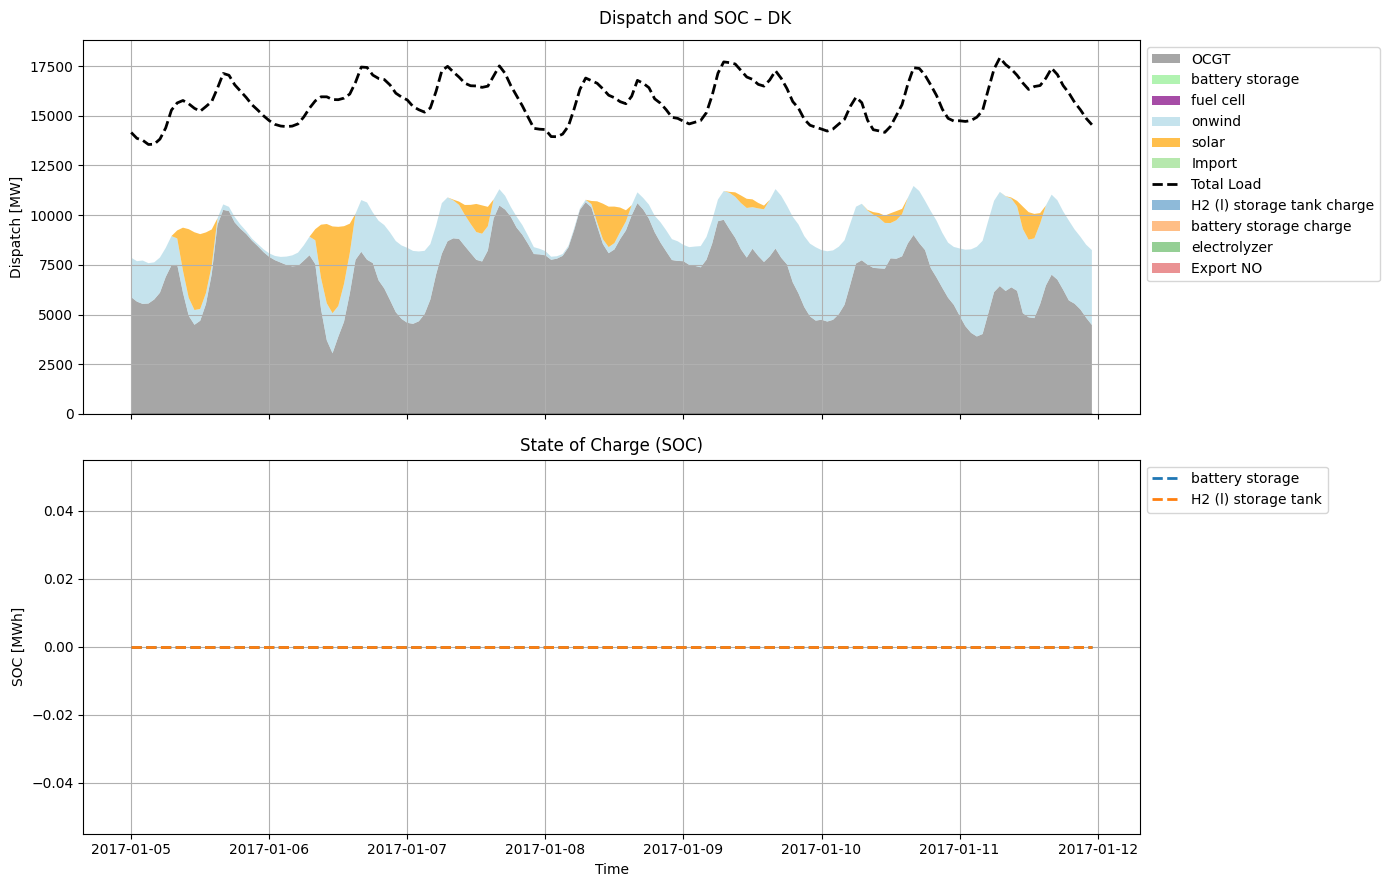

C:\Users\Jeppe Urup Byberg\AppData\Local\Temp\ipykernel_20064\2046257734.py:103: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  fallback_cmap = cm.get_cmap('tab20')  # or any other colormap


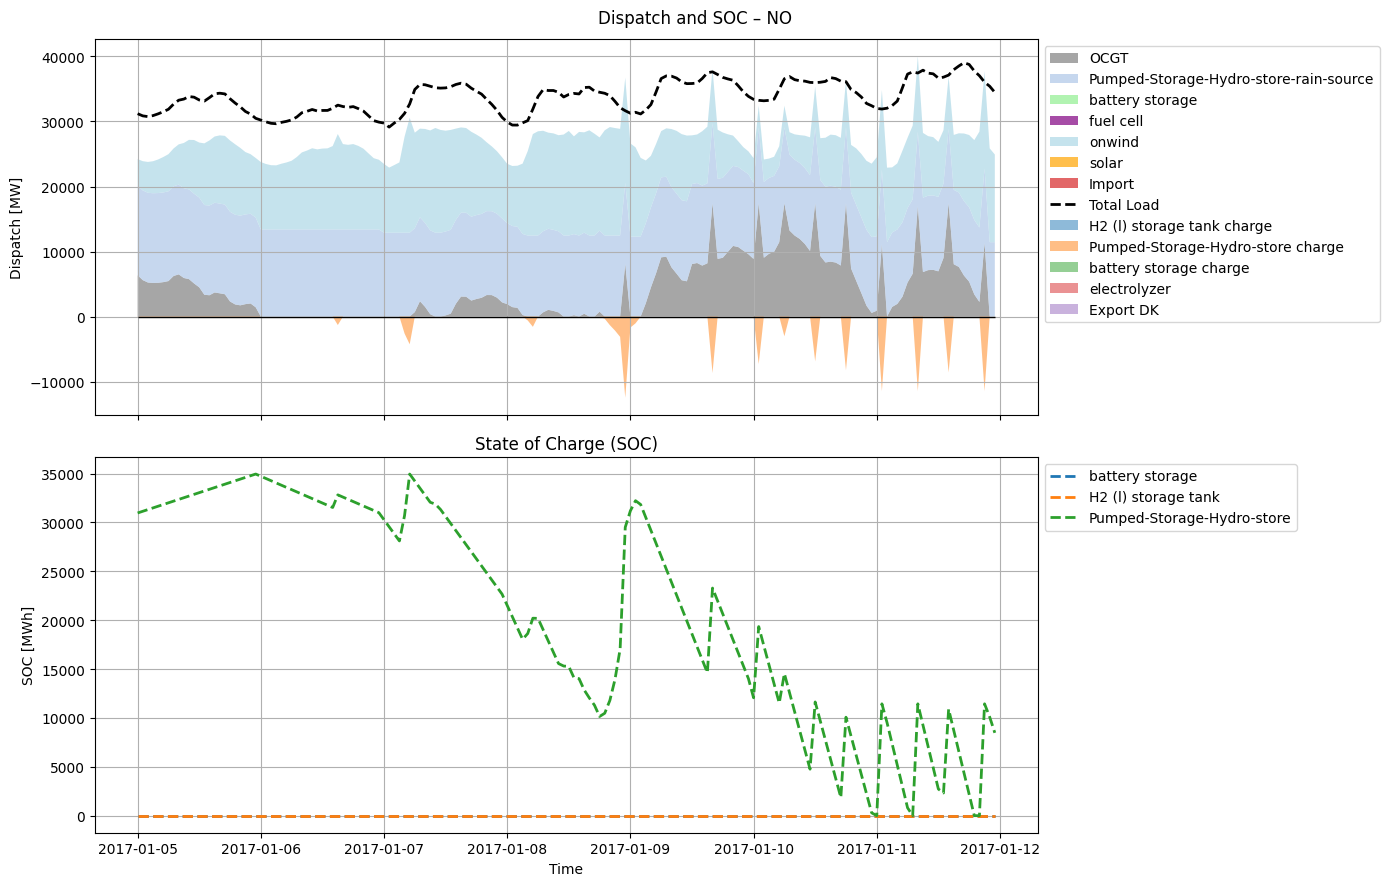

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from ExpandedNetwork import ExpandedNetwork
import pandas as pd

class PlotInternationalDispatchSoC:
    def __init__(self, network: ExpandedNetwork, start: str, end: str):
        self.network = network.network
        self.network1 = network
        self.start = start
        self.end = end

        self.plot_dispatch_and_soc(self.network, self.start, self.end)

    def plot_dispatch_and_soc(self, network, start, end):
        """
        Creates a dispatch + SOC plot for each region in a PyPSA network.

        Assumes that generator/store/link/load names end with the region name, e.g. 'solar DK'.
        """
        ts = pd.date_range(start, end, freq="h")

        # Extract full time series upfront
        generators_t = network.generators_t.p.loc[ts]
        stores_t_p = network.stores_t.p.loc[ts]
        stores_t_e = network.stores_t.e.loc[ts]
        links_t_p0 = network.links_t.p0.loc[ts]
        links_t_p1 = network.links_t.p1.loc[ts]
        loads_t = network.loads_t.p.loc[ts]

        # Infer regions from generator names (e.g., "OCGT DK")
        regions = set(bus.split()[-1] for bus in network.buses.index if "electricity bus" in bus)

        for region in sorted(regions):
            # --------------------------
            # Select components for region
            gen_cols = [col for col in generators_t.columns if col.endswith(region)]
            store_cols = [col for col in stores_t_p.columns if col.endswith(region)]
            link_cols_p1 = [col for col in links_t_p1.columns if col.endswith(region)]
            link_cols_p0 = [col for col in links_t_p0.columns if col.endswith(region)]
            load_cols = [col for col in loads_t.columns if col.endswith(region)]

            # --------------------------
            # Prepare generation (including discharge + fuel cell)
            # gen_df = generators_t[gen_cols].copy()
            gen_df = pd.DataFrame(index=ts)
            for col in ['OCGT', 'onwind', 'solar']:
                gen_df[col] = generators_t[f"{col} {region}"]
            for col in ['fuel cell', 'battery storage', 'Hydro Energy']:
                if col == 'fuel cell':
                    gen_df[col] = -links_t_p1[col]
                if col == 'battery storage':
                    gen_df[col] = 

            
                if any("battery" in c for c in store_cols):
                    for col in store_cols:
                        if "battery" in col:
                            gen_df[f"battery storage {region}"] = stores_t_p[col].clip(lower=0)
                if any("fuel cell" in c for c in link_cols_p1):
                    for col in link_cols_p1:
                        if "fuel cell" in col:
                            gen_df[f"fuel cell {region}"] = -links_t_p1[col]
                if any("Pumped" in c for c in link_cols_p0):
                    for col in link_cols_p0:
                        if "Pumped" in col:
                            gen_df[f"Pumped-Storage-Hydro-store {region}"] = -links_t_p1[col]
            
            gen_df = gen_df.fillna(0)
            gen_df = gen_df.sort_index(axis=1)

            # --------------------------
            # Charging
            bat_charge_df = pd.DataFrame(index=ts)
            for col in store_cols:
                name = col.replace(f" {region}", "")
                bat_charge_df[name + " charge"] = stores_t_p[col].clip(upper=0)
            for col in link_cols_p1:
                if "electrolysis" in col:
                    name = col.replace(f" {region}", "")
                    bat_charge_df["electrolyzer"] = links_t_p1[col]
            bat_charge_df = bat_charge_df.fillna(0)
            bat_charge_df = bat_charge_df.sort_index(axis=1)

            # --------------------------
            # Load
            total_load = loads_t[load_cols].sum(axis=1)

            # --------------------------
            # SOC
            soc_df = stores_t_e[store_cols].copy()
            soc_df.columns = [col.replace(f" {region}", "") for col in soc_df.columns]

            # --------------------------
            # --- Add interconnector flows ---
            interconnector_cols = [col for col in links_t_p0.columns if f"{region} -" in col or f"- {region}" in col]

            for col in interconnector_cols:
                raw_flow = links_t_p0[col].copy()

                # Flip sign if it's an export (region is on the left)
                if col.startswith(f"{region} -"):
                    flow = -raw_flow
                else:
                    flow = raw_flow

                # Split into positive (import) and negative (export)
                import_flow = flow.clip(lower=0)   # to gen_df
                export_flow = flow.clip(upper=0)   # to bat_charge_df

                # Extract the other region name (for label clarity)
                other_region = col.replace(region, "").replace("-", "").strip()

                gen_df[f"Import {other_region}"] = import_flow
                bat_charge_df[f"Export {other_region}"] = export_flow

            fallback_cmap = cm.get_cmap('tab20')  # or any other colormap
            gen_colors = []
            for i, col in enumerate(gen_df.columns):
                gen_type = ' '.join(col.split(' ')[:-1])  # removes the final part (region)
                if gen_type in self.network1.colors:
                    gen_colors.append(self.network1.colors[gen_type])
                else:
                    gen_colors.append(fallback_cmap(i % fallback_cmap.N))  # rotate through fallback colors
            gen_labels = [' '.join(col.split(' ')[:-1]) for col in gen_df.columns]

            # Plot
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9), sharex=True)
            plt.suptitle(f"Dispatch and SOC – {region}")

            # Dispatch
            ax1.stackplot(ts, gen_df.T.values, labels=gen_labels, alpha=0.7, colors = gen_colors)
            ax1.plot(ts, total_load, label="Total Load", color="black", linestyle="--", linewidth=2)
            ax1.stackplot(ts, bat_charge_df.T.values, labels=bat_charge_df.columns, alpha=0.5)

            ax1.hlines(0, xmin=ts[0], xmax=ts[-1], color="black", linewidth=1)
            ax1.set_ylabel("Dispatch [MW]")
            ax1.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
            ax1.grid(True)

            # SOC
            ax2.set_title("State of Charge (SOC)")
            for column in soc_df.columns:
                ax2.plot(ts, soc_df[column], label=column, linestyle="--", linewidth=2)
            ax2.set_ylabel("SOC [MWh]")
            ax2.set_xlabel("Time")
            ax2.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0))
            ax2.grid(True)

            plt.tight_layout()
            plt.show()
PlotInternationalDispatchSoC(Expanded_Heat_Network, start="2017-01-05 00:00", end="2017-01-11 23:00")
